In [26]:
import warnings
warnings.filterwarnings('ignore')
import os
import gc
from IPython.display import clear_output
gc.enable()

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from einops import rearrange, reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm.notebook import tqdm
from glob import glob
from modules import TransUNET, FocalLoss

seed = 42

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


**Two underlying concepts**

**ViT**
<div><table><tr><td>
<img src="vit1.png" width="400"/>
<td><img src="vit2.ppm" width="400"/>
    </tr></table>
</div>

**Transformer UNET**
<img src="tunet.png" width="600" height="800"/>

In [4]:
BATCH_SIZE = 4
IMAGE_SIZE = 128
epochs = 200
num_classes = 3
PATH = os.path.join(os.getcwd() + '/breast')

label_to_int = {'normal': 0, 'benign': 1, 'malignant': 2}
int_to_label = {0: 'normal', 1: 'benign', 2: 'malignant'}

In [5]:
train_transforms = A.Compose([
                      A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, 
                                                    sat_shift_limit=0.2, 
                                                    val_shift_limit=0.2, 
                                                    p=0.2),      
                      A.RandomBrightnessContrast(brightness_limit=0.2, 
                                                 contrast_limit=0.2, 
                                                 p=0.9)],p=0.2),
                      A.ToGray(p=0.05),
                      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
                      A.Cutout(num_holes=8, max_h_size=10, max_w_size=10, fill_value=0, p=0.1),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

valid_transforms = A.Compose([
                      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

invTrans = A.Compose([A.Normalize(mean=[ 0., 0., 0. ],
                                  std=[ 1/0.229, 1/0.224, 1/0.225 ], max_pixel_value=1.0),
                      A.Normalize(mean=[ -0.485, -0.456, -0.406 ],
                                  std=[ 1., 1., 1. ], max_pixel_value=1.0),
                      ], p=1.0)

def inverse_transforms(tensor):
    if tensor.size(0) == 1 and len(tensor.shape) == 4:
        tensor.squeeze_(0)
    sample = {"image": tensor.cpu().detach().numpy().transpose(1,2,0)}
    image = invTrans(**sample)["image"]

    return image

In [6]:
original_paths = glob(os.getcwd() + "/breast/*/*).png")
mask_paths = glob(os.getcwd() + "/breast/*/*mask.png")

original_paths = sorted([str(path) for path in original_paths])
mask_paths = sorted([str(path) for path in mask_paths])
labels = [label_to_int.get(path.split("\\")[-1].split()[0]) for path in mask_paths]

df = pd.DataFrame(data={"image": original_paths, "mask": mask_paths, "label": labels})

In [7]:
x_train, x_valid = train_test_split(df, train_size=700, shuffle=True, stratify=df["label"], random_state=seed)
x_test, x_valid = train_test_split(x_valid, test_size=55, shuffle=True, stratify=x_valid["label"], random_state=seed)

print(f"Train size: {len(x_train)}, validation size: {len(x_valid)}, test size: {len(x_test)}.")

Train size: 700, validation size: 55, test size: 25.


In [9]:
class BreastDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data.reset_index(drop=True)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ix):
        row = self.data.loc[ix].squeeze()
        image = cv2.imread(row["image"])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = Image.open(row["image"])
        # image = np.array(image)
        
        mask = cv2.imread(row["mask"])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        mask = torch.as_tensor(mask[None]/255, dtype=torch.float32)
        
        label = torch.as_tensor(row["label"], dtype=torch.int64)

        sample = self.transforms(**{"image": image})
        image = sample["image"]
        
        return image, mask, label
    
    def collate_fn(self, batch):
        images, masks, labels = list(zip(*batch))
        images, masks, labels = [[tensor[None].to(device) for tensor in btc] for btc in [images, masks, labels]]
        images, masks, label = [torch.cat(tensors) for tensors in [images, masks, labels]]
        return images, masks, label

In [16]:
train_ds = BreastDataset(x_train, train_transforms)
valid_ds = BreastDataset(x_valid, valid_transforms)
test_ds = BreastDataset(x_test, valid_transforms)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=valid_ds.collate_fn)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=test_ds.collate_fn)

In [27]:
model = TransUNET(image_size=128, in_channels=3, out_channels=128, num_heads=4, mlp_dim=512, 
                  block_num=8, patch_dim=16, num_classes=num_classes).to(device)

xe_loss_cls = nn.CrossEntropyLoss()
bce_loss_masks = nn.BCEWithLogitsLoss()
# xe_loss_masks = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, min_lr=1e-6)

In [65]:
def train_one_batch(data, model, optimizer, cls_loss, msk_loss):
    model.train()
    images, masks, labels = data
    
    optimizer.zero_grad()
    out, cls = model(images)
    loss_cls = cls_loss(cls, labels)
    loss_msk = msk_loss(out, masks)
    loss = (loss_cls + loss_msk) * 0.5
    loss.backward()
    optimizer.step()
    
    pred_labels = torch.max(cls, 1)[1]
    cls_accuracy = (labels == pred_labels).float().mean()
    msk_accuracy = (torch.max(out, 1)[1] == masks).float().mean()
    
    return loss.item(), cls_accuracy.item(), msk_accuracy.item()

@torch.no_grad()
def validate_one_batch(data, model, cls_loss, msk_loss):
    model.eval()
    images, masks, labels = data
    out, cls = model(images)
    loss_cls = cls_loss(cls, labels)
    loss_msk = msk_loss(out, masks)
    loss = (loss_cls + loss_msk) * 0.5
    
    pred_labels = torch.max(cls, 1)[1]
    cls_accuracy = (labels == pred_labels).float().mean()
    msk_accuracy = (torch.max(out, 1)[1] == masks).float().mean()
    
    return loss.item(), cls_accuracy.item(), msk_accuracy.item()

@torch.no_grad()
def check_holdout(dl, model, threshold=0.5):
    model.eval()
    plt.figure(figsize=(20, 20))
    i = 1
    for data in dl:
        ix = np.random.randint(0, 2)
        if ix:
            image, mask, label = data
            out, cls = model(image)
            
            pred_label = torch.max(cls, 1)[1][0].item()
            pred_label = int_to_label.get(pred_label)
            
            image = inverse_transforms(image[0])
            label = int_to_label.get(int(label))
            
            mask = mask[0].cpu().detach().numpy().squeeze()
            image[mask == 1, :] = (0.74,0,0)
            
            out = (torch.sigmoid(out)[0].cpu().detach().numpy() > threshold).astype(int).squeeze()
            image[out == 1, :] = (0, 0.31, 0)
            
            plt.subplot(5, 4, i)
            plt.title(f"Image with orig. mask ({label}) / pred. mask ({pred_label})")
            plt.imshow(image)
            i += 1
    plt.tight_layout()
    plt.show()
    plt.pause(0.01)

In [ ]:
train_losses, valid_losses = [], []

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    
    tq_bar = tqdm(train_dl, total=len(train_dl), desc=f'Train step {epoch+1}')
    epoch_train_losses = []
    for _, batch in enumerate(tq_bar):
        loss, cls_acc, msk_acc = train_one_batch(batch, model, optimizer, xe_loss_cls, bce_loss_masks)
        epoch_train_losses.append(loss)
        tq_bar.set_postfix(loss=np.mean(epoch_train_losses), cur_cls_acc=cls_acc, cur_msk_acc=msk_acc)
    train_losses.append(np.mean(epoch_train_losses))
    
    tq_bar = tqdm(valid_dl, total=len(valid_dl), desc=f'Validation step {epoch+1}')
    epoch_valid_losses = []
    for _, batch in enumerate(tq_bar):
        loss, cls_acc, msk_acc = validate_one_batch(batch, model, xe_loss_cls, bce_loss_masks)
        epoch_valid_losses.append(loss)
        tq_bar.set_postfix(loss=np.mean(epoch_valid_losses), cur_cls_acc=cls_acc, cur_msk_acc=msk_acc)
    valid_losses.append(np.mean(epoch_valid_losses))
    clear_output()
    
    if (epoch+1) % 5 == 0 or (epoch+1) == epochs:
        check_holdout(test_dl, model)
        checkpoint = {
            'model': model,
        }
        torch.save(checkpoint, "model.pth")
        
    scheduler.step(np.mean(epoch_valid_losses))

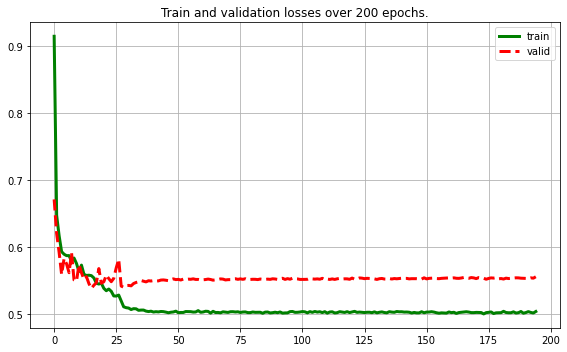

In [59]:
plt.figure(figsize=(8, 5))
plt.title(f"Train and validation losses over {epochs} epochs.")
plt.plot(train_losses, lw=3, c='g', label="train")
plt.plot(valid_losses, lw=3, ls="--", c='r', label="valid")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

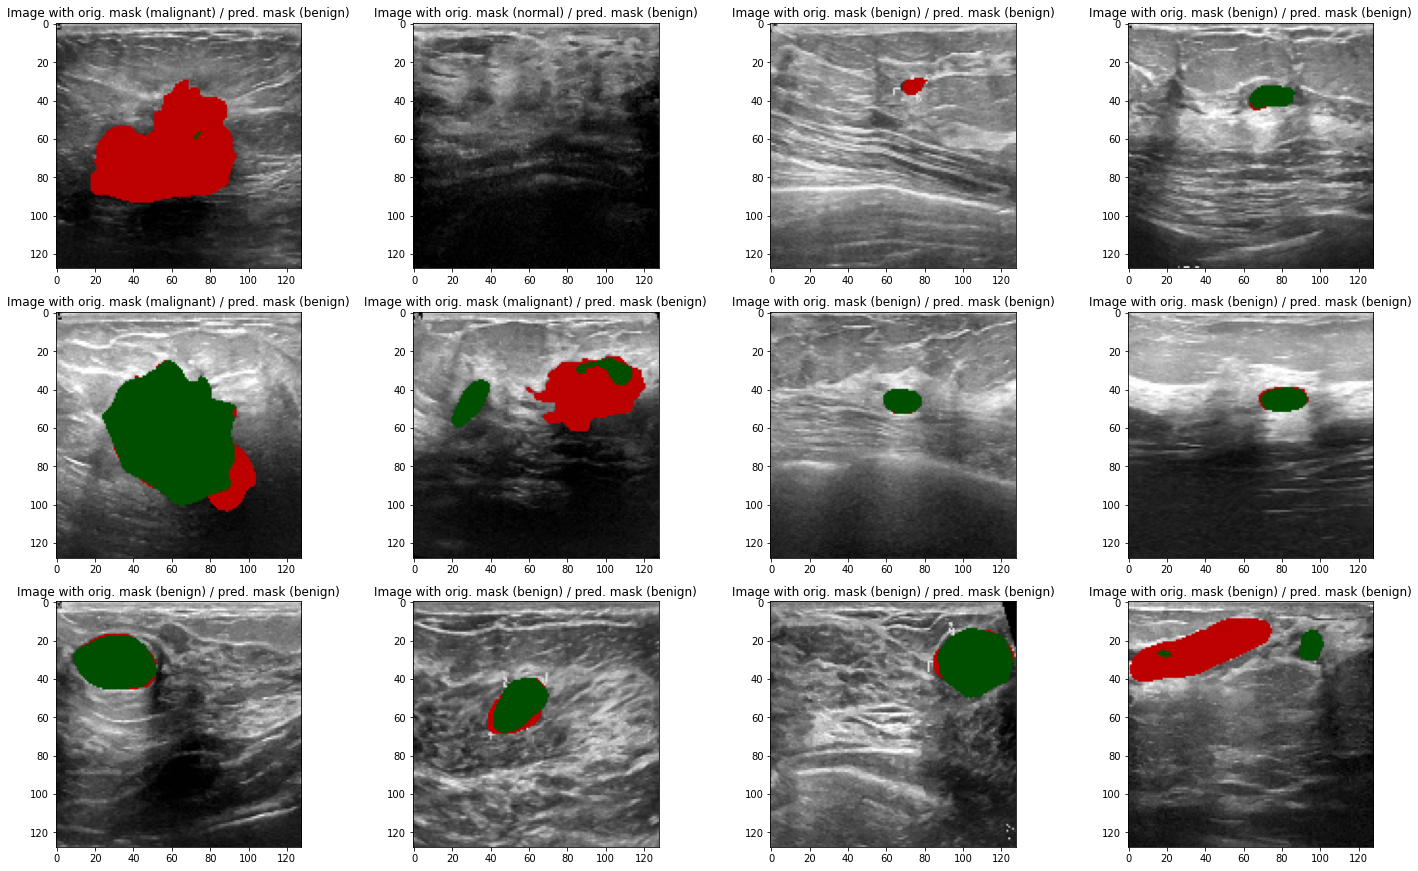

In [55]:
check_holdout(test_dl, model, threshold=0.5)

In [61]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1.0000000000000002e-06
    maximize: False
    weight_decay: 0.01
)

**Thoughts to improve**

Model learned to find some mask patterns, but failed image classification task (More than 55% of "benign" class and 17% of malignant, so the classifier chooses the most frequent as it sees no difference in benign and malignant or normal). What next:
* early stopping;
* use focal loss for classification;
* use dice loss in mask predictions;
* use dataset with >> more samples, less normal (empty) masks;
* use pretrained ViT (e.g. from https://huggingface.co/docs/transformers/model_doc/vit#transformers.ViTForImageClassification);
* make mlp_head in ViT more complex -> add one or few fully connected layers;
* use multiple outputs instead of using inbuilt ViT: output_shape = (B, Num_classes=3, IM_SIZE, IM_SIZE) to get masks for each given class;
* use RandomWeighteSampler in train dataloader to eliminate class imbalance;
* exotic approach: add Discriminator network;
* xe_loss with non-binary mask case -> ignore_index=0 as background class, blackout background by setting 0 for all regions except given multiple colored regions + slice <code>_, preds = torch.max(output[0, 1:], 0)</code> bg class in predictons...

In [75]:
x_train["label"].value_counts(normalize=True)

1    0.56
2    0.27
0    0.17
Name: label, dtype: float64